# Medical Equipment Analysis

This notebook combines three key analyses:
1. **Exploratory Data Analysis (EDA)**: Overview of data quality, distributions, and categorical counts.
2. **Utilization Metrics**: Analysis of usage rates, operating hours, and procedure counts.
3. **Financial & ROI Analysis**: Calculation of revenue, costs, net profit, and ROI.

---

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")

# --- Load and Clean Data ---

# Get the correct file path (go up one level from analysis folder)
file_path = "../data/processed/medical_equipment_utilization_synthetic_cleaned(in).csv"

raw_df = pd.read_csv(file_path)

# Standardize column names
raw_df.columns = [c.strip().replace(" ", "_") for c in raw_df.columns]
df = raw_df.dropna(axis=1, how="all").copy()

# Clean currency columns
currency_cols = [
    "Cost_per_procedure",
    "Daily_Operating_Cost",
    "Procedure_Revenue",
    "Net-Profit_(daily)",
]
for col in currency_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace("KES", "", case=False, regex=False)
            .str.replace(",", "", regex=False)
            .str.replace(" ", "", regex=False)
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Clean numeric columns
numeric_cols = [
    "Available_Hours",
    "Actual_Operating_Hours",
    "Utilization_Rate",
    "Number_of_Procedures",
]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Convert Date
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

print("Data loaded successfully.")
print(f"Rows: {len(df)}, Columns: {len(df.columns)}")
df.head()

Data loaded successfully.
Rows: 3000, Columns: 15


,Date,Equipment_ID,Equipment_Type,Department,Available_Hours,Actual_Operating_Hours,Utilization_Rate,Number_of_Procedures,Cost_per_procedure,Daily_Operating_Cost,Procedure_Revenue,Day_of_Week,Month,Is_Weekend,Net-Profit_(daily)
0,2023-12-22,MRI_0001,MRI Scanner,Radiology,12,0.5,0.04,1,30000,5000,30000,Friday,December,False,25000
1,2023-01-24,XRAY_0002,X-Ray Machine,Radiology,19,13.5,0.71,20,2000,1500,40000,Tuesday,January,False,38500
2,2023-12-19,CT_0003,CT Scanner,Radiology,8,6.7,0.84,7,10000,3000,70000,Tuesday,December,False,67000
3,2023-12-12,CT_0004,CT Scanner,Radiology,18,9.2,0.51,20,10000,3000,200000,Tuesday,December,False,197000
4,2023-12-31,XRAY_0005,X-Ray Machine,Radiology,11,8.3,0.75,22,2000,1500,44000,Sunday,December,True,42500


## 1. Data Overview & EDA
Basic statistics, missing values, and distribution plots.

In [6]:
print("=== Info ===")
df.info()

print("\n=== Missing Values ===")
print(df.isna().sum())

print("\n=== Descriptive Statistics ===")
print(df.describe().T)

=== Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    3000 non-null   datetime64[ns]
 1   Equipment_ID            3000 non-null   object        
 2   Equipment_Type          3000 non-null   object        
 3   Department              3000 non-null   object        
 4   Available_Hours         3000 non-null   int64         
 5   Actual_Operating_Hours  3000 non-null   float64       
 6   Utilization_Rate        3000 non-null   float64       
 7   Number_of_Procedures    3000 non-null   int64         
 8   Cost_per_procedure      3000 non-null   int64         
 9   Daily_Operating_Cost    3000 non-null   int64         
 10  Procedure_Revenue       3000 non-null   int64         
 11  Day_of_Week             3000 non-null   object        
 12  Month                   3000 non-nu

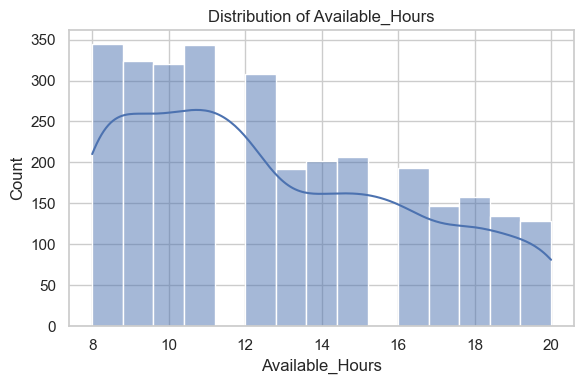

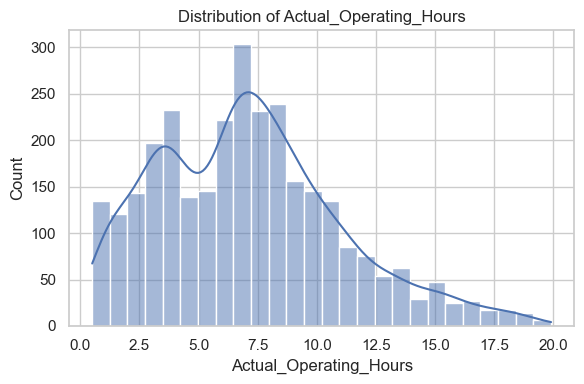

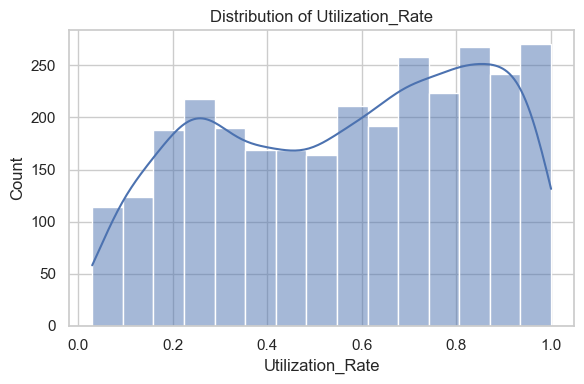

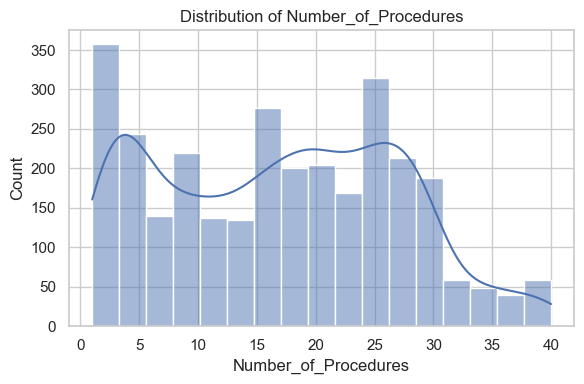

In [7]:
# --- Numeric Distributions ---
num_plot_cols = [
    "Available_Hours",
    "Actual_Operating_Hours",
    "Utilization_Rate",
    "Number_of_Procedures",
]

for col in num_plot_cols:
    if col in df.columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.tight_layout()
        plt.show()

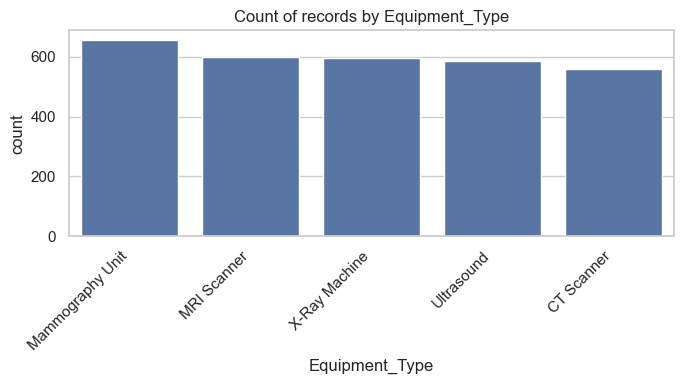

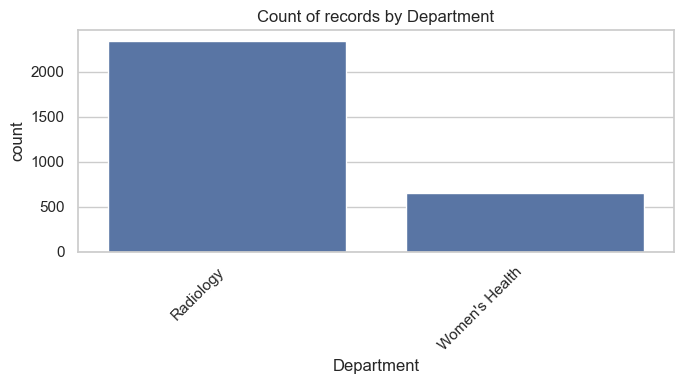

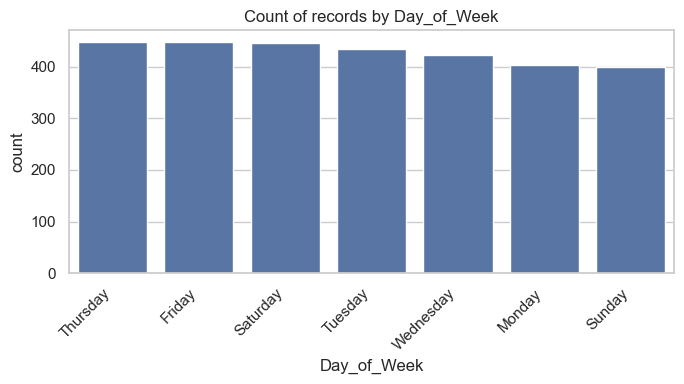

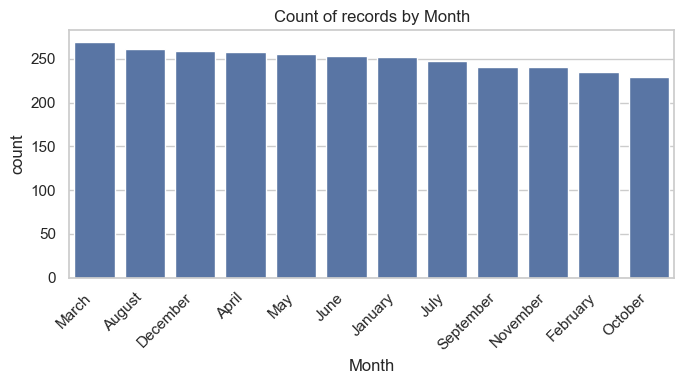

In [8]:
# --- Categorical Counts ---
cat_cols = ["Equipment_Type", "Department", "Day_of_Week", "Month"]

for col in cat_cols:
    if col in df.columns:
        plt.figure(figsize=(7, 4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f"Count of records by {col}")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

## 2. Utilization Metrics
Analyzing utilization rates, operating hours, and procedure volumes by equipment type, department, and time.

In [9]:
# --- Aggregation by Equipment Type ---
util_by_type = (
    df.groupby("Equipment_Type")
    .agg(
        n_days=("Equipment_ID", "count"),
        avg_available_hours=("Available_Hours", "mean"),
        avg_operating_hours=("Actual_Operating_Hours", "mean"),
        avg_utilization_rate=("Utilization_Rate", "mean"),
        avg_procedures_per_day=("Number_of_Procedures", "mean"),
        total_procedures=("Number_of_Procedures", "sum"),
    )
    .sort_values("avg_utilization_rate", ascending=False)
)

print("Utilization by Equipment Type:")
display(util_by_type.round(2))

# --- Aggregation by Department ---
util_by_dept = (
    df.groupby("Department")
    .agg(
        n_days=("Equipment_ID", "count"),
        avg_utilization_rate=("Utilization_Rate", "mean"),
        total_procedures=("Number_of_Procedures", "sum"),
    )
    .sort_values("avg_utilization_rate", ascending=False)
)

print("\nUtilization by Department:")
display(util_by_dept.round(2))

Utilization by Equipment Type:


,n_days,avg_available_hours,avg_operating_hours,avg_utilization_rate,avg_procedures_per_day,total_procedures
Equipment_Type,,,,,,
Ultrasound,588,10.01,7.98,0.80,26.95,15849
Mammography Unit,656,13.93,8.54,0.62,17.98,11795
X-Ray Machine,595,14.09,8.56,0.62,18.56,11046
CT Scanner,560,13.80,8.27,0.61,18.08,10122
MRI Scanner,601,11.93,2.20,0.19,3.05,1831



Utilization by Department:


,n_days,avg_utilization_rate,total_procedures
Department,,,
Women's Health,656,0.62,11795
Radiology,2344,0.55,38848


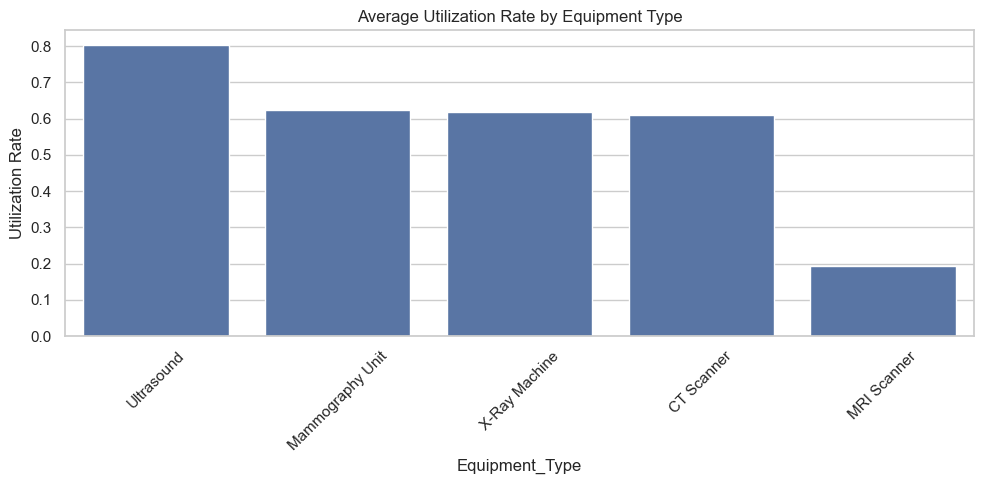

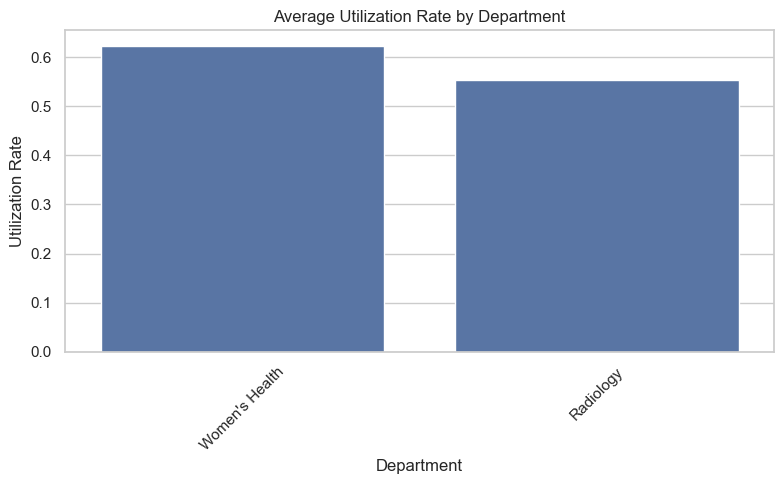

In [10]:
# --- Visualization of Utilization ---

# By Type
plt.figure(figsize=(10, 5))
sns.barplot(data=util_by_type.reset_index(), x="Equipment_Type", y="avg_utilization_rate")
plt.title("Average Utilization Rate by Equipment Type")
plt.ylabel("Utilization Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# By Department
plt.figure(figsize=(8, 5))
sns.barplot(data=util_by_dept.reset_index(), x="Department", y="avg_utilization_rate")
plt.title("Average Utilization Rate by Department")
plt.ylabel("Utilization Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

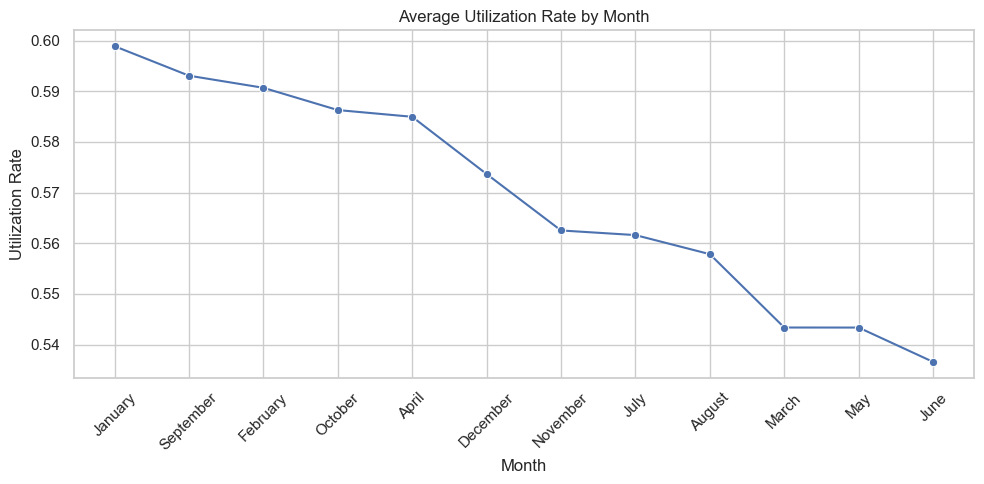

In [11]:
# --- Monthly Trend ---
if "Month" in df.columns:
    util_by_month = (
        df.groupby("Month")
        .agg(
            avg_utilization_rate=("Utilization_Rate", "mean"),
            total_procedures=("Number_of_Procedures", "sum"),
        )
        .sort_values("avg_utilization_rate", ascending=False)
    )
    
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=util_by_month.reset_index(), x="Month", y="avg_utilization_rate", marker="o")
    plt.title("Average Utilization Rate by Month")
    plt.ylabel("Utilization Rate")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 3. Financial & ROI Analysis
Calculating Return on Investment (ROI), Profit Margins, and daily Profit/Loss.

In [12]:
# --- ROI Metrics Calculation ---

# Group by Equipment Type
roi_by_type = (
    df.groupby("Equipment_Type")
    .agg(
        n_days=("Equipment_ID", "count"),
        total_procedures=("Number_of_Procedures", "sum"),
        total_revenue=("Procedure_Revenue", "sum"),
        total_operating_cost=("Daily_Operating_Cost", "sum"),
        total_net_profit=("Net-Profit_(daily)", "sum"),
    )
)

roi_by_type["roi_%"] = 100 * roi_by_type["total_net_profit"] / roi_by_type["total_operating_cost"]
roi_by_type["profit_margin_%"] = 100 * roi_by_type["total_net_profit"] / roi_by_type["total_revenue"]
roi_by_type["avg_profit_per_day"] = roi_by_type["total_net_profit"] / roi_by_type["n_days"]

print("Financial Metrics by Equipment Type:")
display(roi_by_type.round(2))

# Group by Department
roi_by_dept = (
    df.groupby("Department")
    .agg(
        n_days=("Equipment_ID", "count"),
        total_procedures=("Number_of_Procedures", "sum"),
        total_revenue=("Procedure_Revenue", "sum"),
        total_operating_cost=("Daily_Operating_Cost", "sum"),
        total_net_profit=("Net-Profit_(daily)", "sum"),
    )
)

roi_by_dept["roi_%"] = 100 * roi_by_dept["total_net_profit"] / roi_by_dept["total_operating_cost"]
roi_by_dept["avg_profit_per_day"] = roi_by_dept["total_net_profit"] / roi_by_dept["n_days"]

print("\nFinancial Metrics by Department:")
display(roi_by_dept.round(2))

Financial Metrics by Equipment Type:


,n_days,total_procedures,total_revenue,total_operating_cost,total_net_profit,roi_%,profit_margin_%,avg_profit_per_day
Equipment_Type,,,,,,,,
CT Scanner,560,10122,101220000,1680000,99540000,5925.00,98.34,177750.00
MRI Scanner,601,1831,54930000,3005000,51925000,1727.95,94.53,86397.67
Mammography Unit,656,11795,58975000,656000,58319000,8890.09,98.89,88900.91
Ultrasound,588,15849,47547000,588000,46959000,7986.22,98.76,79862.24
X-Ray Machine,595,11046,22092000,892500,21199500,2375.29,95.96,35629.41



Financial Metrics by Department:


,n_days,total_procedures,total_revenue,total_operating_cost,total_net_profit,roi_%,avg_profit_per_day
Department,,,,,,,
Radiology,2344,38848,225789000,6165500,219623500,3562.14,93696.03
Women's Health,656,11795,58975000,656000,58319000,8890.09,88900.91


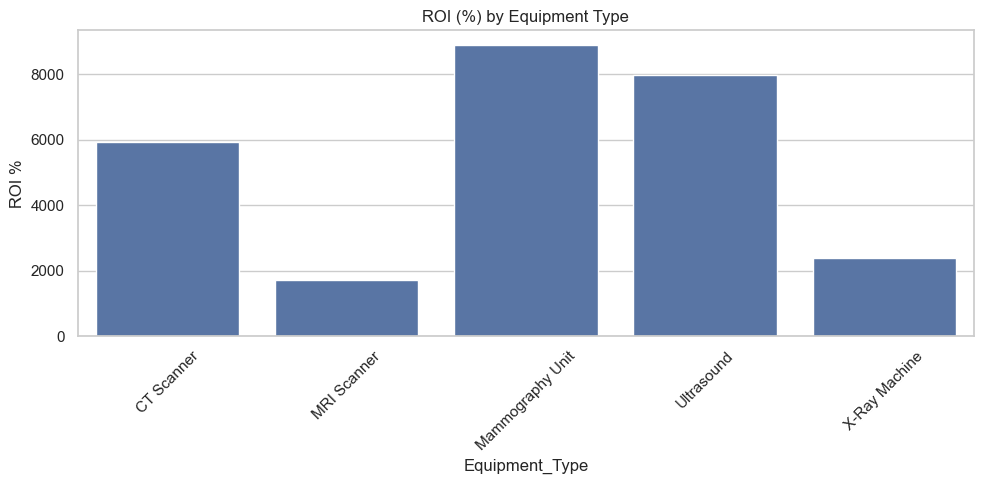

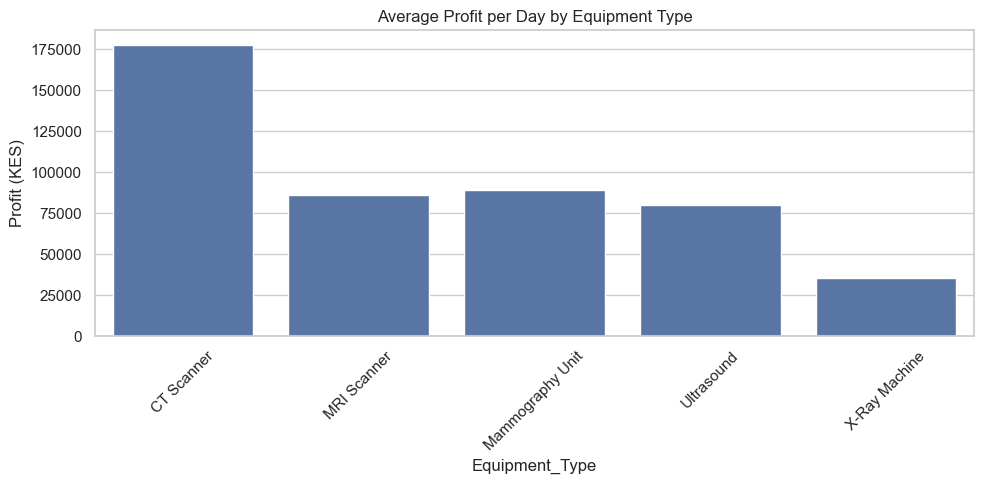

In [13]:
# --- Visualization of Financial Metrics ---

# ROI by Type
plt.figure(figsize=(10, 5))
sns.barplot(data=roi_by_type.reset_index(), x="Equipment_Type", y="roi_%")
plt.title("ROI (%) by Equipment Type")
plt.ylabel("ROI %")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Profit per Day by Type
plt.figure(figsize=(10, 5))
sns.barplot(data=roi_by_type.reset_index(), x="Equipment_Type", y="avg_profit_per_day")
plt.title("Average Profit per Day by Equipment Type")
plt.ylabel("Profit (KES)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()